In [1]:
import os
import scanpy as sc
sc.set_figure_params(dpi=100, dpi_save=1000, vector_friendly=True)
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
font_dirs = "/data/projects/robin/fonts"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.pyplot.rcParams['font.family'] = "Arial"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")

In [12]:
adata = sc.read("../ps_per_disease/ROI.h5ad")

In [4]:
data = sc.read("../xenium_outs/adata_complete_reduced_withTransformedMC.h5ad")
data = data[data.obs.polygon_flags.isin(adata.obs.index)]

In [13]:
df = data.obs[["polygon_flags", "celltype_l1"]]

In [14]:
def get_prop(df):
    df['celltype_l1'] = df['celltype_l1'].tolist()
    counts = pd.crosstab(df['polygon_flags'], df['celltype_l1'])
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    return proportions

In [15]:
df_props = get_prop(df)

/tmp/ipykernel_2633/3799865196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['celltype_l1'] = df['celltype_l1'].tolist()


In [25]:
adata.obs["Disease"]

polygon_flags
0_0011216_ANCA_X17                        ANCA
0_0011216_ANCA_X18                        ANCA
0_0011216_ANCA_X19                        ANCA
0_0011216_ANCA_X20                        ANCA
0_0011216_ANCA_X20,2_0011216_ANCA_X20     ANCA
                                         ...  
9_0011762_Cntrl_X1                       Cntrl
9_0018775_ANCA_X58                        ANCA
9_0018775_ANCA_X60                        ANCA
9_0018775_ANCA_X63                        ANCA
9_0018775_Cntrl_X57                      Cntrl
Name: Disease, Length: 974, dtype: category
Categories (4, object): ['ANCA', 'Cntrl', 'GBM', 'SLE']

In [30]:
df_props["Disease"] = adata[df_props.index].obs["Disease"].tolist()

<Axes: xlabel='Disease', ylabel='PEC'>

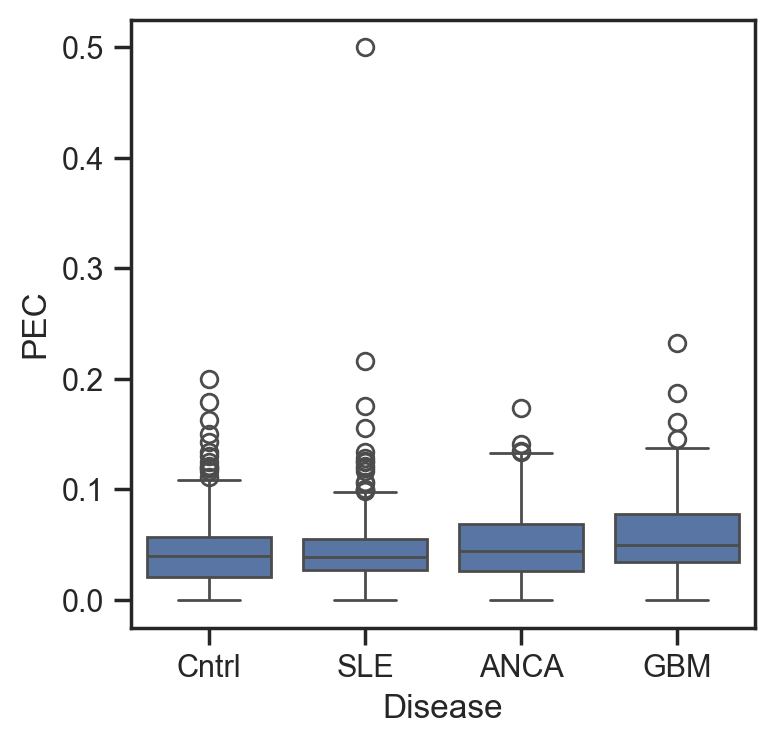

In [32]:
sns.boxplot(data=df_props, x="Disease", y="PEC", order=["Cntrl", "SLE", "ANCA", "GBM"])

In [8]:
coors = {}
for i in [0,1,2,3]:
    pc = i+1
    pca_df = pd.DataFrame(adata.obsm["X_pca"][:,i], index=adata.obs.index, columns=[f"PC{pc}"]).loc[df_props.index]
    coors[pc] = df_props.corrwith(pca_df[f"PC{pc}"]).sort_values()
    if pc==1:
        idxs = coors[1].index.tolist()
    else:
        coors[pc] = coors[pc].loc[idxs]

In [9]:
toplot = pd.concat(coors,axis=1)
toplot.columns = [f"PC{col}" for col in toplot.columns]

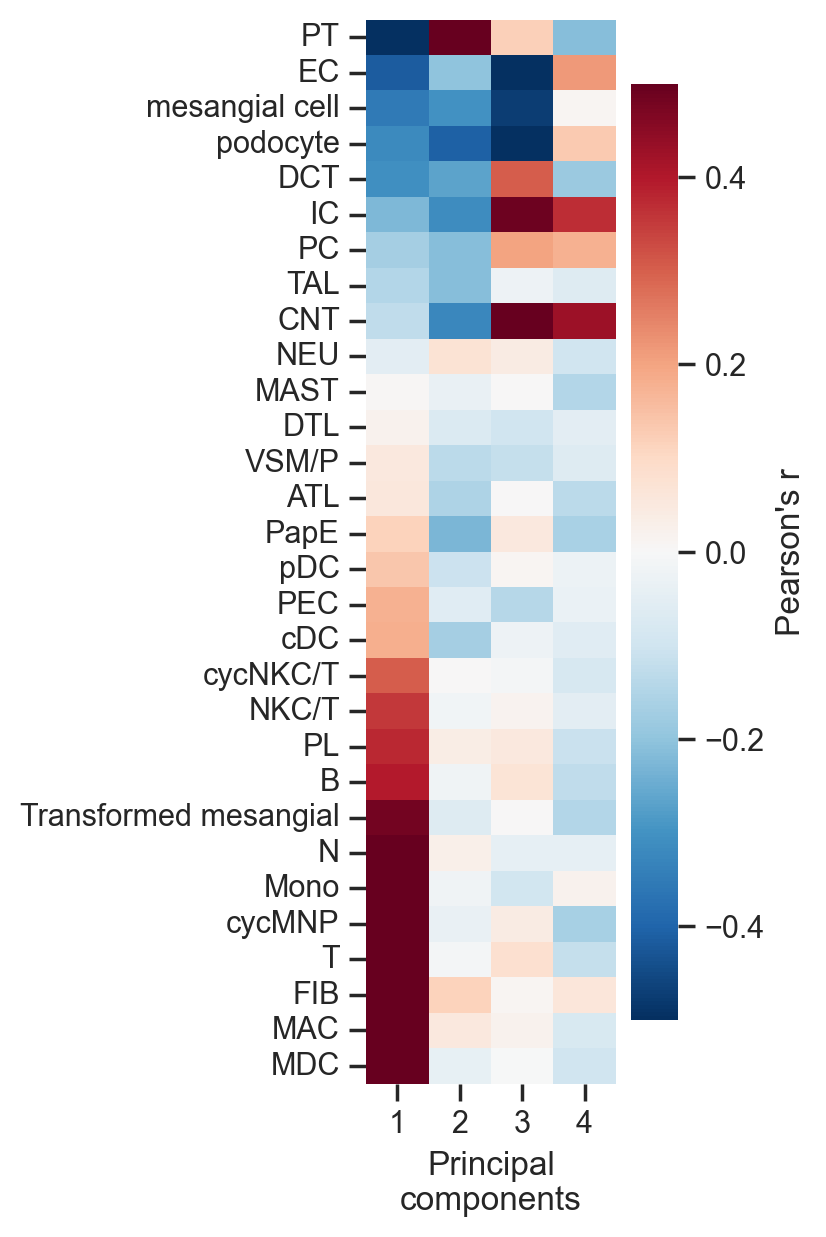

In [10]:
plt.figure(figsize=(2,7))
ax=sns.heatmap(toplot, cmap="RdBu_r", center=0, vmin=-0.5, vmax=0.5, cbar_kws={'label': "Pearson's r"})
plt.ylabel("")
ax.set_xticklabels([1,2,3,4])
plt.xlabel("Principal\ncomponents")
plt.savefig("PC_correlations_with_celltype_fracs.pdf", bbox_inches="tight")

In [16]:
Fib_genes = [e for e in ['COL16A1', 'COL1A1', 'COL3A1', 'COL6A3', 'COL7A1','COL8A1', 'FN1'] if e in adata.var.index.tolist()]
Fib_genes = sorted(list(set(Fib_genes)))
sc.tl.score_genes(adata, Fib_genes, score_name="Fibrosis", use_raw=False)

In [32]:
from scipy.stats import pearsonr

In [34]:
r, p = pearsonr(adata.obs["PC1"], adata.obs["Fibrosis"])
r,p

(0.7115428952248523, 3.813362996007835e-151)

<Figure size 500x500 with 0 Axes>

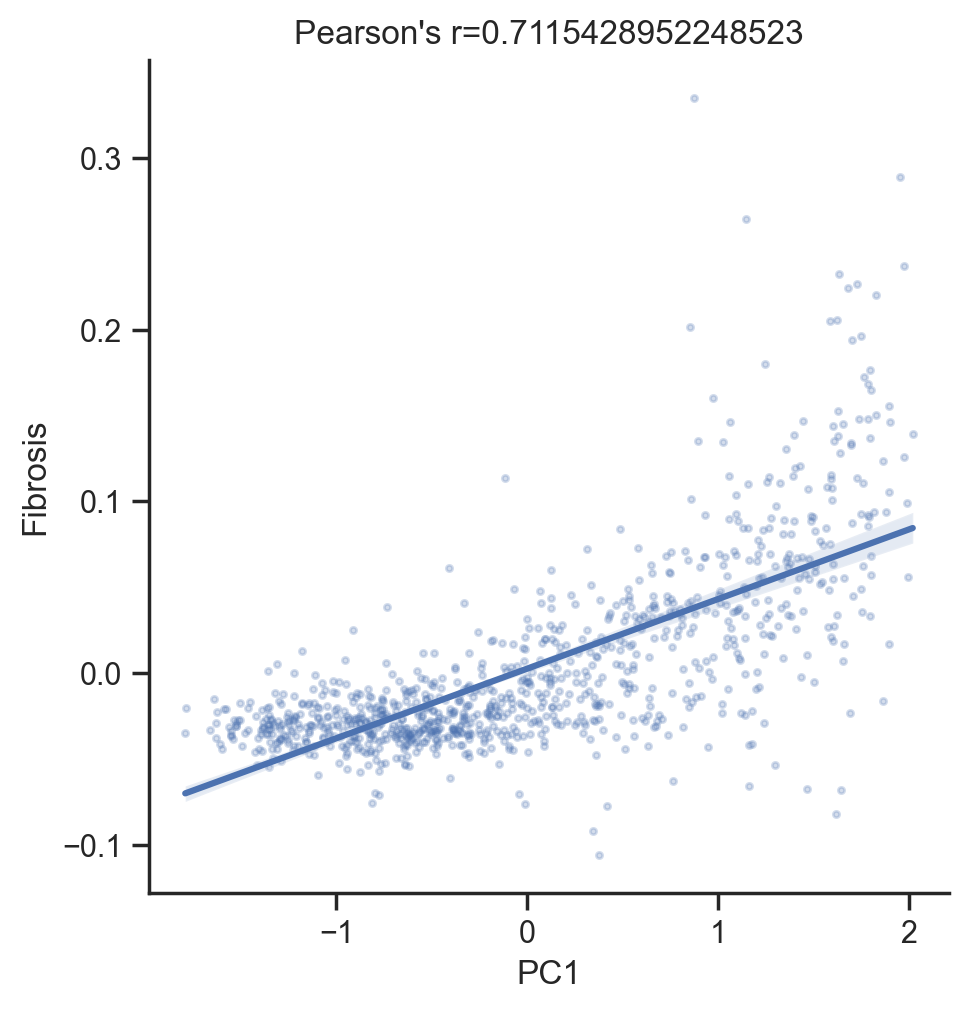

In [36]:
plt.figure(figsize=(5,5))
sns.lmplot(data=adata.obs,x="PC1",y="Fibrosis", order=1, ci=95, scatter=True, palette="colorblind",
          scatter_kws={'alpha': 0.24, 's': 5})
ax.set_ylabels(f"Fibrosis")
plt.title(f"Pearson's r={r}")
#plt.savefig("PC1_PDGF_TGF_scores.pdf", bbox_inches="tight")
plt.show()

In [11]:
from anndata import AnnData

In [12]:
adata.obs["PC1"] = adata.obsm["X_pca"][:,0]

In [13]:
tgf_genes = [e for e in ["ACVR1", "APC", "ARID4B", "BCAR3", "BMP2", "BMPR1A", "BMPR2", "CDH1", "CDK9", 
                        "CDKN1C", "CTNNB1", "ENG", "FKBP1A", "FNTA", "FURIN", "HDAC1", "HIPK2", "ID1", 
                        "ID2", "ID3", "IFNGR2", "JUNB", "KLF10", "LEFTY2", "LTBP2", "MAP3K7", "NCOR2", 
                        "NOG", "PMEPA1", "PPM1A", "PPP1CA", "PPP1R15A", "RAB31", "RHOA", "SERPINE1", 
                        "SKI", "SKIL", "SLC20A1", "SMAD1", "SMAD3", "SMAD6", "SMAD7", "SMURF1", "SMURF2", 
                        "SPTBN1", "TGFB1", "TGFBR1", "TGIF1", "THBS1", "TJP1", "TRIM33", "UBE2D3", 
                        "WWTR1", "XIAP", "TGFB1", "TGFBI", "TGFBR1"] if e in adata.var.index.tolist()]
pdgf_genes = [e for e in ["PDGFA", "PDGFB", "PDGFRB", "PDGFRA", 
                          "PIK3CB", "PIK3R2", "KANK1", "BIN2", "WDR48", "STAT1", "STRN", "SOS1", 
                         "PIK3CA", "KDR", "KRAS", "PDGFRA", "ETV6", "GOLGA4", "FIP1L1", "PIK3R1", 
                         "STAT3", "HRAS", "GRB2", "NRAS", "HRAS"] if e in adata.var.index.tolist()]
tgf_genes = sorted(list(set(tgf_genes)))
pdgf_genes = sorted(list(set(pdgf_genes)))

/tmp/ipykernel_2169/2476744855.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("polygon_flags").agg("mean")
/tmp/ipykernel_2169/2476744855.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs1["expression"] = adata_glom_PECs.obs["PDGF"].tolist()
/tmp/ipykernel_2169/2476744855.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

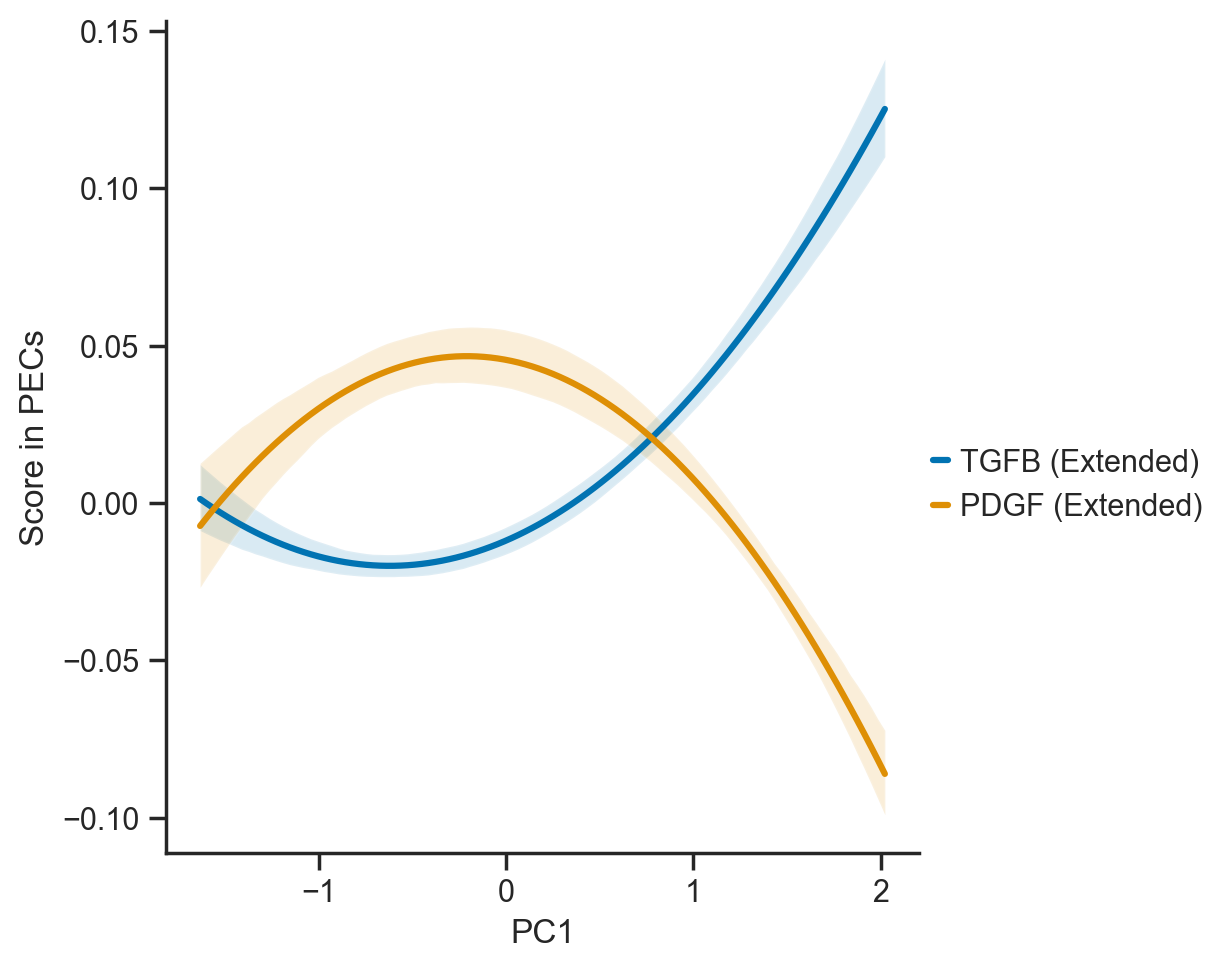

In [14]:
df_ps = adata.obs[["PC1"]]
sub = data[data.obs.is_in_glom]
sub = sub[sub.obs.Biopsy_ID.astype(str)!="nan"]
sub = sub[sub.obs.glom_ID.isin(df_ps.index.tolist())]
sub_1 = sub[sub.obs["celltype_l1"]=="PEC"]
df = sub_1.to_df(layer="counts")
df = pd.concat([df, sub_1.obs[["polygon_flags"]]], axis=1)
df = df.groupby("polygon_flags").agg("mean")
adata_glom_PECs = AnnData(df, obs=df_ps.loc[df.index.tolist()])
sc.pp.normalize_total(adata_glom_PECs)
sc.pp.log1p(adata_glom_PECs)
sc.tl.score_genes(adata_glom_PECs, tgf_genes, score_name="TGFB", use_raw=False)
sc.tl.score_genes(adata_glom_PECs, pdgf_genes, score_name="PDGF", use_raw=False)
obs1 = adata_glom_PECs.obs[["PC1"]]
obs1["expression"] = adata_glom_PECs.obs["PDGF"].tolist()
obs1["gene"] = "PDGF (Extended)"
obs2 = adata_glom_PECs.obs[["PC1"]]
obs2["expression"] = adata_glom_PECs.obs["TGFB"].tolist()
obs2["gene"] = "TGFB (Extended)"
obs = pd.concat([obs2, obs1], axis=0)

ax=sns.lmplot(data=obs,x="PC1",y="expression", hue="gene", order=2, ci=95, scatter=False, palette="colorblind")
ax.set_ylabels(f"Score in PECs")
ax.legend.set_title("")
plt.savefig("PC1_PDGF_TGF_scores.pdf", bbox_inches="tight")
plt.show()

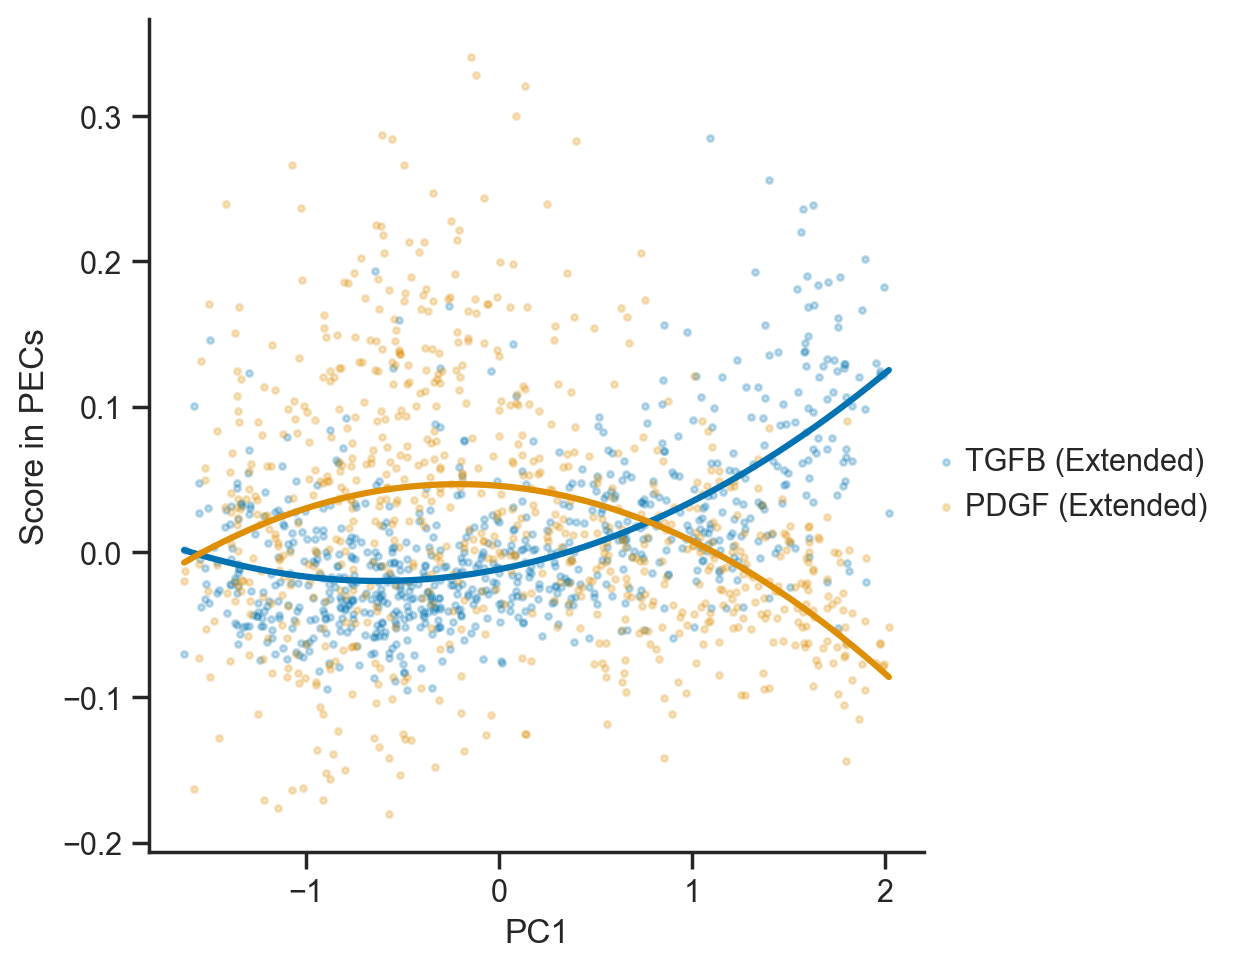

In [15]:
ax=sns.lmplot(data=obs,x="PC1",y="expression", hue="gene", order=2, ci=None, scatter=True, palette="colorblind",
             scatter_kws={'alpha': 0.24, 's': 5})
ax.set_ylabels(f"Score in PECs")
ax.legend.set_title("")
plt.savefig("PC1_PDGF_TGF_scores_all_scatter.pdf", bbox_inches="tight")

plt.show()

## quadrants

In [40]:
adata_old = sc.read("../ps_per_disease/all_ps.h5ad")[adata.obs.index]

In [55]:
adata_old.obs['quadrants'] = pd.cut(adata_old.obs["dpt_pseudotime"], 4, labels=["1", "2", "3", "4"])
adata.obs['quadrants'] = pd.cut(adata.obs["PC1"], 4, labels=["1", "2", "3", "4"])

In [56]:
tab = pd.crosstab(adata.obs['quadrants'], adata_old.obs['quadrants'])

In [57]:
adata_old.obs['quadrants'].value_counts()

quadrants
2    466
3    417
4     48
1     43
Name: count, dtype: int64

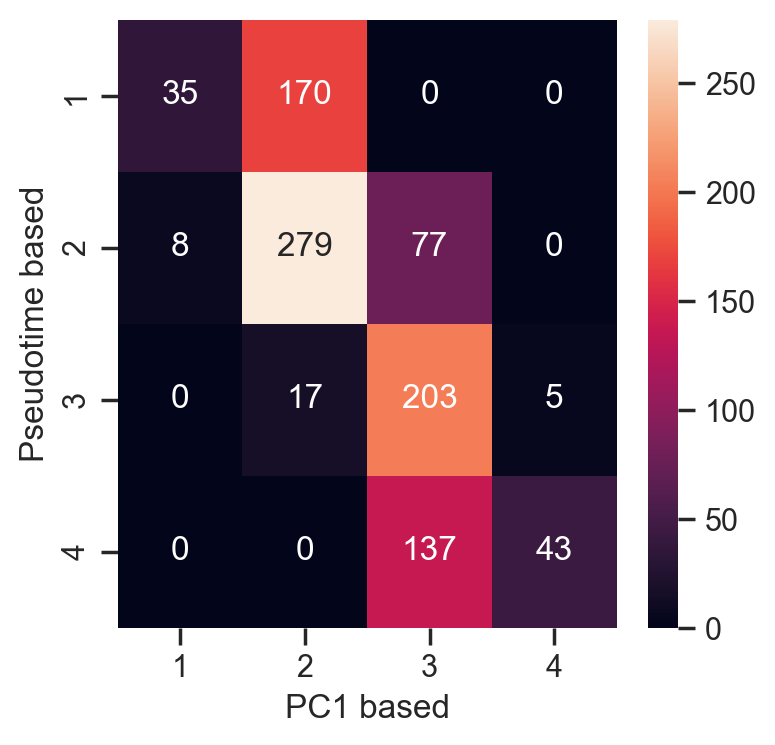

In [58]:
sns.heatmap(tab, annot=True, fmt="d")
plt.xlabel("PC1 based")
plt.ylabel("Pseudotime based")
plt.savefig("quadrant_comparison.pdf", bbox_inches="tight")


In [61]:
tab = pd.crosstab(adata.obs['quadrants'], adata.obs['Disease'])
order = ["Cntrl", "SLE", "ANCA", "GBM"]
tab = tab[order]
tab.rename(columns={"GBM": "aGBM"}, inplace=True)

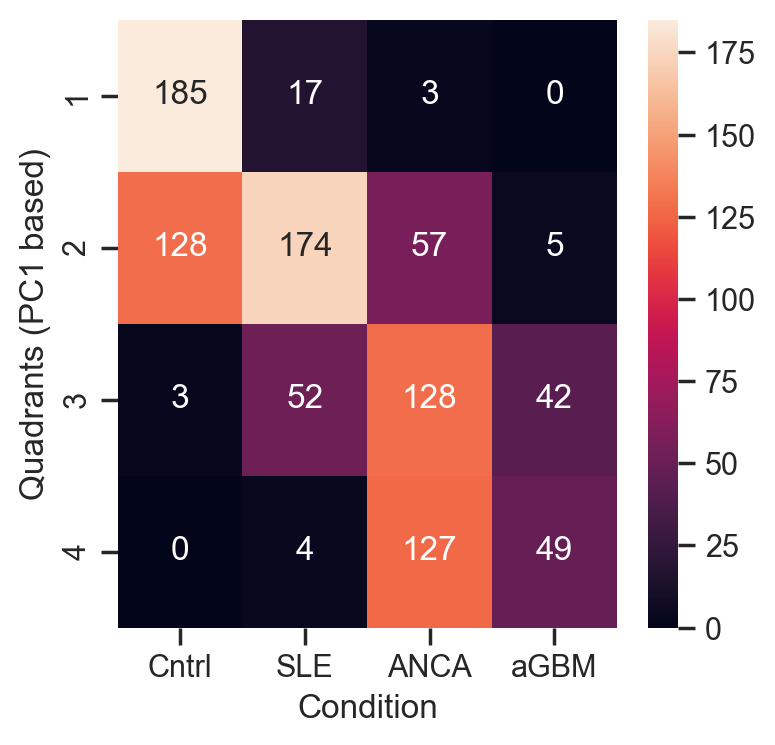

In [62]:
sns.heatmap(tab, annot=True, fmt="d")
plt.ylabel("Quadrants (PC1 based)")
plt.xlabel("Condition")
plt.savefig("quadrant_by_disease.pdf", bbox_inches="tight")


In [63]:
tab = pd.crosstab(adata_old.obs['quadrants'], adata_old.obs['Disease'])
order = ["Cntrl", "SLE", "ANCA", "GBM"]
tab = tab[order]
tab.rename(columns={"GBM": "aGBM"}, inplace=True)

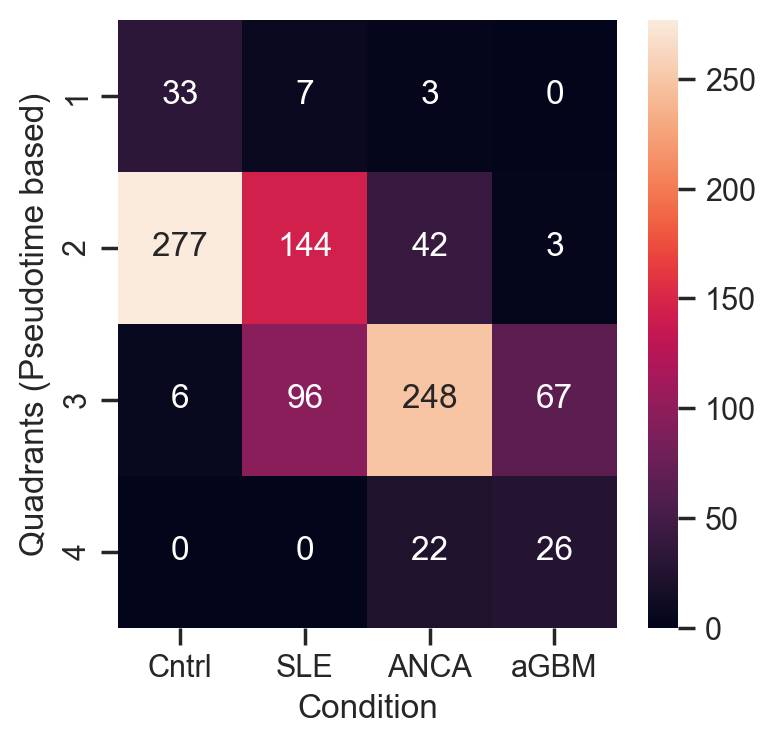

In [64]:
sns.heatmap(tab, annot=True, fmt="d")
plt.ylabel("Quadrants (Pseudotime based)")
plt.xlabel("Condition")
plt.savefig("ps_quadrant_by_disease.pdf", bbox_inches="tight")
